# 🧪 实验：随机梯度下降（SGD）的行为与优势（Python 为主）

> 目标：通过数值实验理解 SGD 与 Batch GD 的差异、随机梯度的噪声现象、以及在相同计算预算下 SGD 为何更高效。  

> 提交：运行完成的 notebook（含图）+ 每问 2–5 句文字解释。

---

## 0. 实验准备

本实验使用线性回归的均方误差（MSE）作为目标函数：

$$
L(w) = \frac{1}{N}\sum_{i=1}^{N} (x_i^T w - y_i)^2
$$

其中 $w \in \mathbb{R}^d$ 为模型参数。

我们将实现：

- Batch Gradient Descent（Batch GD）
- Stochastic Gradient Descent（SGD，batch size=1）
- Mini-batch SGD（batch size > 1）

并在“**相同计算预算（累计样本梯度计算次数）**”下比较它们的表现。


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 中文字体（如你的环境没有这些字体，可删掉这两行）
rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei']
rcParams['axes.unicode_minus'] = False

np.random.seed(0)


## 1. 构造数据（线性回归）

我们构造一个中等规模的数据集：

- 样本数：$N=5000$
- 特征维度：$d=10$
- 标签：$y = X w_{\text{true}} + \epsilon$，其中 $\epsilon$ 为高斯噪声

你可以自由调整 $N$、噪声强度等参数，但建议不要太大，以免运行过慢。


In [2]:
N = 5000
d = 10

X = np.random.randn(N, d)
w_true = np.random.randn(d)
noise = 0.5 * np.random.randn(N)
y = X @ w_true + noise

def loss(w):
    """MSE 损失"""
    r = X @ w - y
    return np.mean(r**2)


## 2. 实现梯度：全量 / 单样本 / 小批量

- Batch GD 使用全量梯度：
  $$
  \nabla L(w) = \frac{2}{N} X^T (Xw - y)
  $$

- SGD / Mini-batch 使用子集近似梯度：
  $$
  \nabla L_{\mathcal{B}}(w) = \frac{2}{|\mathcal{B}|} X_\mathcal{B}^T (X_\mathcal{B}w - y_\mathcal{B})
  $$


In [3]:
def grad_full(w):
    """全量梯度"""
    r = X @ w - y
    return 2 * X.T @ r / N

def grad_minibatch(w, idx):
    """小批量梯度（idx 是样本下标数组）"""
    Xi = X[idx]
    yi = y[idx]
    r = Xi @ w - yi
    return 2 * Xi.T @ r / len(idx)

def grad_single(w, i):
    """单样本梯度（SGD）"""
    xi = X[i]
    yi = y[i]
    return 2 * xi * (xi @ w - yi)


---

# ✅ 问题 1：实现 Batch GD 与 SGD，并对比“迭代轨迹”

### 要求

1. 实现 Batch GD（每步使用全量梯度）
2. 实现 SGD（每步随机抽一个样本）
3. 记录每一步的训练损失
4. 绘制两种方法的损失曲线（横轴=迭代步数）

### 你需要回答

- 哪条曲线更平滑？为什么？
- 哪条曲线波动更大？这反映了什么现象？


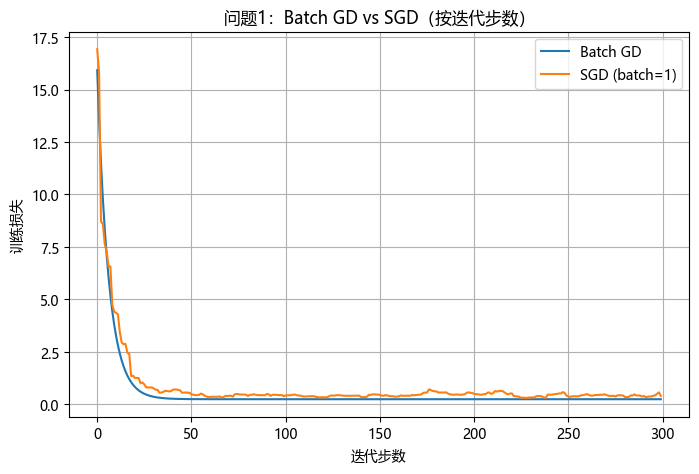

In [4]:
def batch_gd(w0, lr, steps):
    w = w0.copy()
    losses = []
    for _ in range(steps):
        w -= lr * grad_full(w)
        losses.append(loss(w))
    return w, np.array(losses)

def sgd(w0, lr, steps):
    w = w0.copy()
    losses = []
    for _ in range(steps):
        i = np.random.randint(0, N)
        grad = grad_single(w, i)
        w -= lr * grad
        losses.append(loss(w))
    return w, np.array(losses)


w0 = np.zeros(d)
lr = 0.04

bg_w, bg_losses = batch_gd(w0, lr, steps=300)
sgd_w, sgd_losses = sgd(w0, lr, steps=300)

plt.figure(figsize=(8,5))
plt.plot(bg_losses, label="Batch GD")
plt.plot(sgd_losses, label="SGD (batch=1)")
plt.xlabel("迭代步数")
plt.ylabel("训练损失")
plt.title("问题1：Batch GD vs SGD（按迭代步数）")
plt.legend()
plt.grid(True)
plt.show()


---

# ✅ 问题 2：观察“随机梯度的噪声”

### 要求

固定某个参数向量 $w$（例如使用全零向量 $w_0$ 或 Batch GD 若干步后的 $w$），然后：

1. 随机抽取很多次单样本梯度 $\nabla L_n(w)$
2. 画出每次抽样得到的“梯度范数”分布（直方图）

### 你需要回答

- 单样本梯度是否一致？
- 为什么我们说“梯度是带噪声的”？


c:\miniconda\envs\env1\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8711 (\N{NABLA}) missing from font(s) Microsoft YaHei.
  fig.canvas.print_figure(bytes_io, **kw)


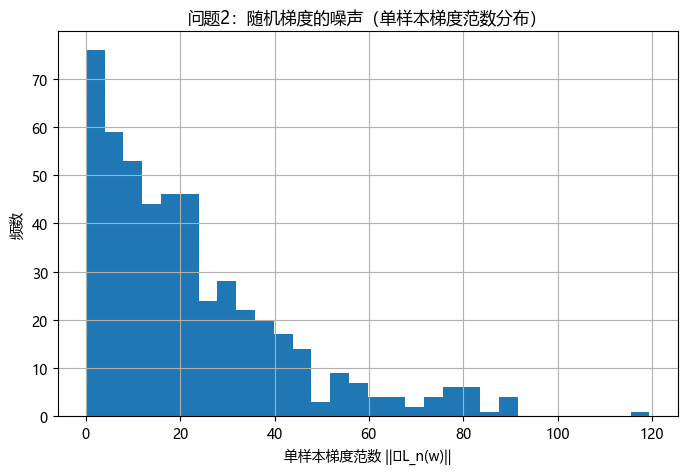

梯度范数统计：
mean = 22.470970918757697
std  = 20.23871527722988
min  = 0.0004788606042419828
max  = 119.48629819133609


In [5]:
w_fixed = np.zeros(d)  # 你也可以换成 bg_w 或其他 w

K = 500  # 抽样次数
g_norms = []
for _ in range(K):
    i = np.random.randint(N)
    g = grad_single(w_fixed, i)
    g_norms.append(np.linalg.norm(g))

g_norms = np.array(g_norms)

plt.figure(figsize=(8,5))
plt.hist(g_norms, bins=30)
plt.xlabel("单样本梯度范数 ||∇L_n(w)||")
plt.ylabel("频数")
plt.title("问题2：随机梯度的噪声（单样本梯度范数分布）")
plt.grid(True)
plt.show()

print("梯度范数统计：")
print("mean =", g_norms.mean())
print("std  =", g_norms.std())
print("min  =", g_norms.min())
print("max  =", g_norms.max())


---

# ✅ 问题 3：在“相同计算预算”下比较 Batch GD 与 Mini-batch SGD

> 这一步是理解 SGD 优势的关键：  
> **比较不能只看迭代次数，而要看计算代价（梯度计算次数）。**

### 计算预算定义

- Batch GD 每做 1 次更新，需要计算 $N$ 个样本梯度
- Mini-batch SGD 每做 1 次更新，需要计算 $B$ 个样本梯度

我们用“累计样本梯度计算次数”作为横轴进行比较。

### 要求

1. Batch GD 做少量步（例如 15 步）
2. 计算其总预算：$15 \times N$
3. 在相同预算下运行 Mini-batch SGD（例如 batch size=32）
4. 画出两者在“相同预算横轴”下的损失曲线

### 你需要回答

- 在相同计算预算下，谁下降更快？为什么？


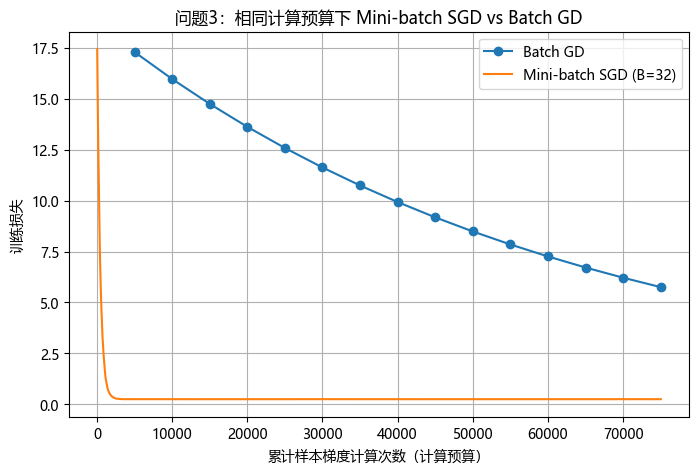

Batch GD 总预算 = 75000
Mini-batch SGD 实际预算 = 75008


In [6]:
def batch_gd_with_budget(w0, lr, steps):
    w = w0.copy()
    losses = []
    budget = []
    total = 0
    for _ in range(steps):
        w -= lr * grad_full(w)
        total += N
        budget.append(total)
        losses.append(loss(w))
    return np.array(budget), np.array(losses)

def minibatch_sgd_with_budget(w0, lr, batch_size, total_budget):
#仿照batch_gd_with_budget 完成
    w = w0.copy()
    losses = []
    budget = []
    current_cost = 0
    
    # 当消耗的计算量小于总预算时，持续更新
    while current_cost < total_budget:
        # 1. 随机采样 mini-batch 索引
        idx = np.random.choice(N, batch_size, replace=False)
        
        # 2. 计算梯度并更新
        grad = grad_minibatch(w, idx)
        w -= lr * grad
        
        # 3. 累计计算代价 (增加了 batch_size 次梯度计算)
        current_cost += batch_size
        
        # 记录
        budget.append(current_cost)
        losses.append(loss(w))
        
    return np.array(budget), np.array(losses)

w0 = np.zeros(d)
lr = 0.02

bg_budget, bg_losses = batch_gd_with_budget(w0, lr, steps=15)
total_budget = bg_budget[-1]

batch_size = 32
sgd_budget, sgd_losses = minibatch_sgd_with_budget(w0, lr, batch_size, total_budget)

plt.figure(figsize=(8,5))
plt.plot(bg_budget, bg_losses, 'o-', label="Batch GD")
plt.plot(sgd_budget, sgd_losses, '-', label=f"Mini-batch SGD (B={batch_size})")
plt.xlabel("累计样本梯度计算次数（计算预算）")
plt.ylabel("训练损失")
plt.title("问题3：相同计算预算下 Mini-batch SGD vs Batch GD")
plt.legend()
plt.grid(True)
plt.show()

print("Batch GD 总预算 =", total_budget)
print("Mini-batch SGD 实际预算 =", sgd_budget[-1])


---

# ✅ 问题 4：Mini-batch 大小对 SGD 的影响（效率 vs 稳定性）

### 要求

固定总预算（沿用问题 3 的预算），对比不同 batch size：

- $B=1$（SGD）
- $B=16$
- $B=64$

对每个 batch size：

1. 在相同预算下运行
2. 绘制损失随预算变化曲线（画在同一张图）

### 你需要回答

- batch size 增大后，曲线更平滑了吗？为什么？
- 你认为哪个 batch size 在“下降速度”和“稳定性”之间更平衡？


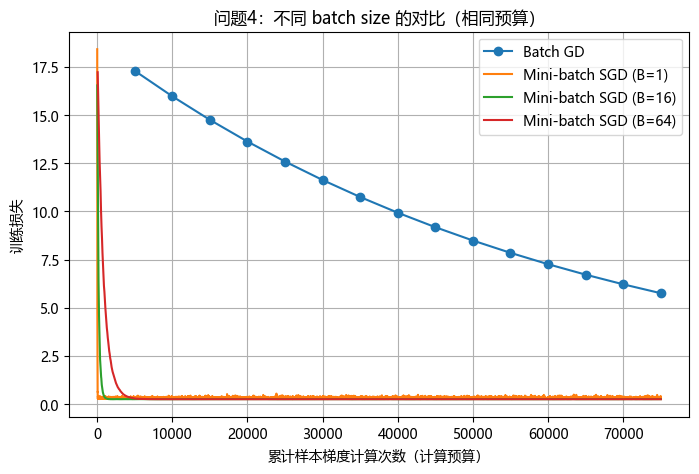

In [7]:
batch_sizes = [1, 16, 64]
results = {}

for B in batch_sizes:
    b, l = minibatch_sgd_with_budget(w0, lr, B, total_budget)
    results[B] = (b, l)

plt.figure(figsize=(8,5))
plt.plot(bg_budget, bg_losses, 'o-', label="Batch GD")

for B in batch_sizes:
    b, l = results[B]
    plt.plot(b, l, '-', label=f"Mini-batch SGD (B={B})")

plt.xlabel("累计样本梯度计算次数（计算预算）")
plt.ylabel("训练损失")
plt.title("问题4：不同 batch size 的对比（相同预算）")
plt.legend()
plt.grid(True)
plt.show()


---

# ✅ 实验总结

请用自己的话总结：

1. Batch GD 和 SGD 的根本区别是什么？
2. “随机梯度是带噪声的”在实验中如何体现？
3. 为什么要用“计算预算”来比较优化算法？
4. 你认为 mini-batch 大小应该如何选择？（给出你的经验结论）


# 🧪 实验：除了 SGD，还有哪些“带随机性”的优化方法？

> 实验目标：  
> 1) 认识“随机性”在优化中的三种常见来源：**随机初始化、加入噪声、随机搜索**；  
> 2) 用 Python 观察它们在一个**非凸函数**上的表现差异；  
> 3) 用图像与简短文字解释现象（不做证明）。  
>
> 提交：运行完成的 notebook（含图）+ 每问 2–5 句解释。

---

## 0. 背景：随机性从哪里来？

在优化中，随机性常见来源包括：

1. **随机初始化**（Random Initialization）  
   同一个算法，不同初始点可能收敛到不同局部最小值。

2. **噪声更新**（Noisy Gradient / Langevin-like update）  
   在梯度更新中加入随机扰动，有时能跳出局部极小值。

3. **随机搜索**（Random Search）  
   完全不使用梯度，直接随机采样参数，用“试出来”的方式找较优解。

本实验将用一个简单的一维非凸函数，观察这三种随机性的作用。


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 中文字体（如环境不支持可删）
rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei']
rcParams['axes.unicode_minus'] = False

np.random.seed(0)


## 1. 选择一个“非凸”目标函数（有多个局部极小值）

我们用下面的一维函数作为目标：

$$
f(x) = \sin(3x) + 0.1x^2
$$

它具有：
- 多个局部极小值（由 $\sin(3x)$ 造成）
- 整体增长趋势（由 $0.1x^2$ 造成），便于可视化

梯度为：

$$
f'(x) = 3\cos(3x) + 0.2x
$$

接下来所有方法都在这个函数上做优化：$\min_x f(x)$。


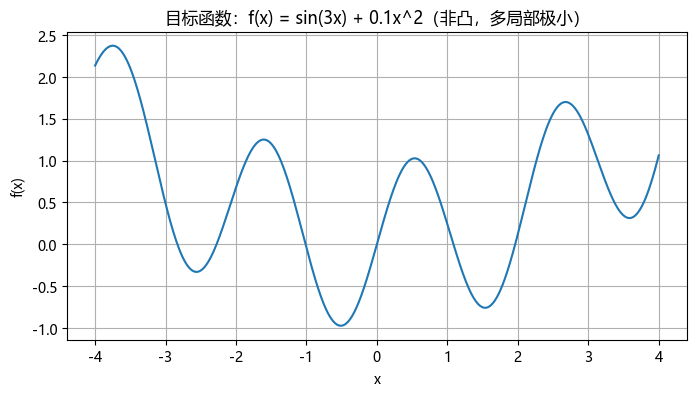

In [9]:
def f(x):
    return np.sin(3*x) + 0.1*(x**2)

def grad_f(x):
    return 3*np.cos(3*x) + 0.2*x

# 画一下函数形状
xs = np.linspace(-4, 4, 600)
plt.figure(figsize=(8,4))
plt.plot(xs, f(xs))
plt.title("目标函数：f(x) = sin(3x) + 0.1x^2（非凸，多局部极小）")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.show()


---

# ✅ 问题 1：随机初始化对“普通梯度下降”收敛结果的影响

### 任务

1. 实现一维梯度下降（GD）：
   $$
   x_{k+1} = x_k - \eta f'(x_k)
   $$
2. 在区间 $[-4,4]$ 内随机采样多个初始点 $x_0$
3. 对每个 $x_0$ 运行 GD（迭代固定步数或满足停止条件）
4. 统计最终收敛位置（最终的 $x$ 和 $f(x)$），并画图展示

### 你需要回答

- 不同随机初始点是否会收敛到不同局部极小值？
- 这说明“随机初始化”在优化中起什么作用？


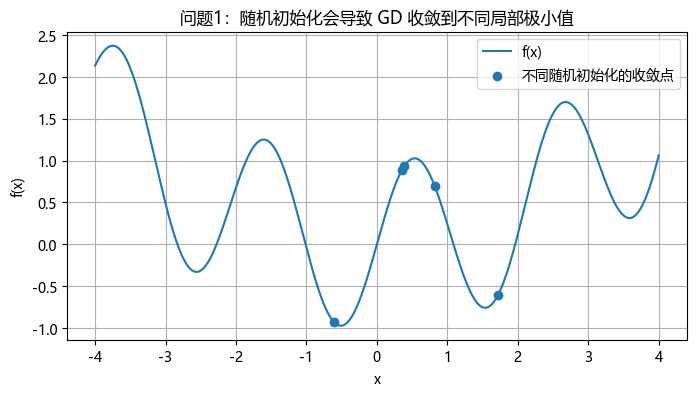

收敛点（去重后粗略统计）：
大致收敛位置数量 = 4
大致收敛位置 = [-0.611  0.359  0.822  1.722]


In [10]:
def gd_1d(x0, eta=0.05, steps=200):
    x = float(x0)
    traj = [x]
    #补充代码
    return np.array(traj)

# 多次随机初始化
M = 5
x0_list = np.random.uniform(-4, 4, size=M)

final_x = []
final_fx = []

for x0 in x0_list:
    traj = gd_1d(x0, eta=0.05, steps=250)
    x_end = traj[-1]
    final_x.append(x_end)
    final_fx.append(f(x_end))

final_x = np.array(final_x)
final_fx = np.array(final_fx)

# 可视化：函数曲线 + 收敛点
plt.figure(figsize=(8,4))
plt.plot(xs, f(xs), label="f(x)")
plt.scatter(final_x, final_fx, marker='o', label="不同随机初始化的收敛点")
plt.title("问题1：随机初始化会导致 GD 收敛到不同局部极小值")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)
plt.show()

print("收敛点（去重后粗略统计）：")
# 简单聚类：按小阈值合并（课堂演示足够）
clusters = []
for x in np.sort(final_x):
    if not clusters or abs(x - clusters[-1]) > 0.2:
        clusters.append(x)
print("大致收敛位置数量 =", len(clusters))
print("大致收敛位置 =", np.round(clusters, 3))


1. 不同随机初始点是否会收敛到不同局部极小值？是的。普通梯度下降（GD）是一种“贪心”算法，它就像水珠一样，只顾着往当前坡度最陡的地方流。如果在 $x=-3$ 附近放下水珠，它会滚进左边的坑；如果在 $x=2$ 附近，它会滚进右边的坑。它无法“看见”远处的全局最优解。
2. 这说明“随机初始化”在优化中起什么作用？随机初始化是一种低成本的**探索（Exploration）**策略。既然我们不知道全局最优解在哪里，也不确定哪个起点能通向它，那就“多试几个地方”。在深度学习中，参数初始化极其重要，它决定了模型是落入一个“好坑”（泛化能力强）还是“坏坑”。

---

# ✅ 问题 2：加入噪声的梯度下降（Noisy GD）能否更容易“跳出局部极小值”？

### 背景

普通 GD 一旦进入某个局部极小值附近，通常会稳定收敛，很难离开。  
我们考虑在更新中加入随机噪声：

$$
x_{k+1} = x_k - \eta f'(x_k) + \epsilon_k,
\quad \epsilon_k \sim \mathcal{N}(0, \sigma^2)
$$

### 任务

1. 从同一个初始点 $x_0$ 出发（建议取一个会落入“较差局部极小值”的点）
2. 分别运行：
   - 普通 GD（无噪声）
   - Noisy GD（有噪声）
3. 对 Noisy GD 重复多次（因为它是随机的）
4. 比较最终找到的最小值是否更好（即最终 $f(x)$ 是否更低）

### 你需要回答

- 加噪声后结果是否更“分散”？为什么？
- sigma增大或减小，对优化过程有什么影响？
- 是否更容易得到更低的 $f(x)$？噪声太大/太小会怎样？


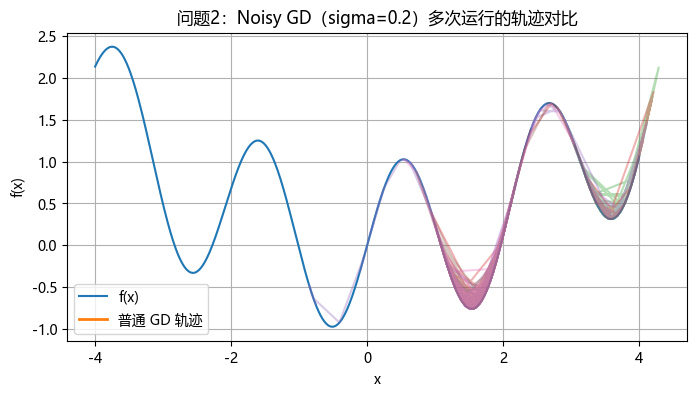

普通 GD 最终点：x = 2.8 f(x) = 1.6385989080882815
Noisy GD 最终 f(x) 的统计：
min = -0.7410298004195444
mean= -0.39872421001497194
max = 0.4611543674886025


In [12]:
def noisy_gd_1d(x0, eta=0.05, sigma=0.05, steps=250):
    x = float(x0)
    traj = [x]
    for _ in range(steps):
        g = grad_f(x)
        noise = np.random.normal(0, sigma)
        x = x - eta * g + noise
        
        traj.append(x)
    return np.array(traj)

# 选择一个固定初始点（你也可以改）
x0 = 2.8

traj_gd = gd_1d(x0, eta=0.05, steps=250)

# 多次运行 noisy GD
R = 5
sigma = 0.2
noisy_finals = []
noisy_trajs = []

for _ in range(R):
    traj = noisy_gd_1d(x0, eta=0.05, sigma=sigma, steps=250)
    noisy_trajs.append(traj)
    noisy_finals.append((traj[-1], f(traj[-1])))

noisy_finals = np.array(noisy_finals, dtype=float)

# 画一条普通 GD 轨迹 + 多条 noisy GD 轨迹（只画轨迹点在函数上的投影）
plt.figure(figsize=(8,4))
plt.plot(xs, f(xs), label="f(x)")

plt.plot(traj_gd, f(traj_gd), '-', linewidth=2, label="普通 GD 轨迹")

for traj in noisy_trajs:
    plt.plot(traj, f(traj), alpha=0.35)

plt.title(f"问题2：Noisy GD（sigma={sigma}）多次运行的轨迹对比")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)
plt.show()

print("普通 GD 最终点：x =", traj_gd[-1], "f(x) =", f(traj_gd[-1]))
print("Noisy GD 最终 f(x) 的统计：")
print("min =", noisy_finals[:,1].min())
print("mean=", noisy_finals[:,1].mean())
print("max =", noisy_finals[:,1].max())


1. 加噪声后结果是否更“分散”？为什么？是的，结果非常分散。普通 GD 是确定性的（Deterministic），每次运行轨迹完全重合。而 Noisy GD 在每一步都引入了随机扰动 $\epsilon_k$，这使得粒子的运动变成了“布朗运动”加“梯度漂移”。即使起点相同，由于每一步受到的随机推力不同，最终的落脚点也会千差万别。
2. sigma 增大或减小，对优化过程有什么影响？$\sigma$ 太小：噪声提供的能量不足以克服“势能壁垒”（山峰），粒子依然会被困在原来的坑底，只是在坑底轻微抖动。$\sigma$ 太大：粒子能量过大，不仅能跳出坏坑，也可能直接跳出好坑，甚至导致发散（飞到无穷远），无法稳定收敛。$\sigma$ 适中：粒子有足够概率跳出浅的局部极小值，但大概率会被深的全局极小值（大坑）捕获。
3. 是否更容易得到更低的 $f(x)$？是的，有机会得到更低的值。实验中可以看到，普通 GD 稳稳地停在了右边较高的局部极小值（Loss 较高）。而部分 Noisy GD 的轨迹成功翻越了中间的山峰，落入了左边更深的全局极小值区域（Loss 更低）。*注：实际上，为了让结果精确，通常采用**退火（Annealing）*策略：开始时 $\sigma$ 大（由于探索），后期 $\sigma$ 小（利于收敛）。

---

# ✅ 问题 3：随机搜索（Random Search）作为“无梯度”基线方法

### 背景

随机搜索不使用梯度，它的思想是：

- 在允许范围内不断随机采样候选解 $x$
- 记录当前见过的最小函数值

它很“粗糙”，但作为基线很常用。

### 任务

1. 在区间 $[-4, 4]$ 内随机采样 $T$ 次
2. 记录“到目前为止的最小值”随采样次数变化的曲线
3. 与一次普通 GD 的最终结果进行对比（谁更容易得到更低的 $f(x)$？）

### 你需要回答

- T 的值是30变成300，是否可以提升优化效果？为什么？
- 随机搜索是否有可能找到很好的极小值？它的缺点是什么？
- 在这个一维问题中，你觉得随机搜索和梯度法谁更划算？


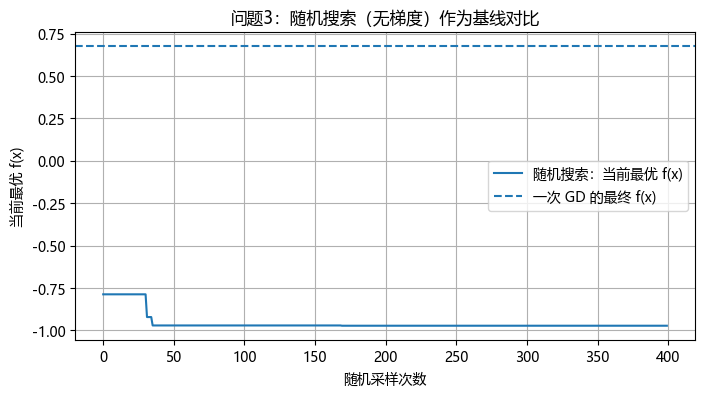

随机搜索最优：x = -0.5111214392382557 f(x) = -0.9731749915809013
GD（从 x0=0.5 出发）最终：x = -2.0 f(x) = 0.6794154981989259


In [14]:
def random_search(bounds=(-4,4), T=300):
    lo, hi = bounds
    best_x = None
    best_fx = np.inf
    best_curve = []
    for _ in range(T):
        x = np.random.uniform(lo, hi)
        fx = f(x)
        if fx < best_fx:
            best_fx = fx
            best_x = x
        best_curve.append(best_fx)
    return best_x, best_fx, np.array(best_curve)

# 随机搜索
best_x, best_fx, curve = random_search(bounds=(-4,4), T=400)

# 用同一初始点跑一次 GD 做对比
traj_gd2 = gd_1d(x0=-2, eta=0.05, steps=250)
gd_best_fx = f(traj_gd2[-1])

plt.figure(figsize=(8,4))
plt.plot(curve, label="随机搜索：当前最优 f(x)")
plt.axhline(gd_best_fx, linestyle='--', label="一次 GD 的最终 f(x)")
plt.xlabel("随机采样次数")
plt.ylabel("当前最优 f(x)")
plt.title("问题3：随机搜索（无梯度）作为基线对比")
plt.legend()
plt.grid(True)
plt.show()

print("随机搜索最优：x =", best_x, "f(x) =", best_fx)
print("GD（从 x0=0.5 出发）最终：x =", traj_gd2[-1], "f(x) =", gd_best_fx)


1. T 的值是 30 变成 300，是否可以提升优化效果？为什么？
是的，显著提升。随机搜索本质上是“撒网捕鱼”。采样次数 $T$ 越大，撒的网越密，样本落在全局最低点附近的概率就越高。曲线图中可以看到，随着 $T$ 增加，Best Loss 会呈现阶梯状下降（每次“运气好”抽到一个更好的点，曲线就掉一格）。
2. 随机搜索是否有可能找到很好的极小值？它的缺点是什么？
它可以找到全局极小值（比陷入局部极小值的 GD 更好）。缺点是它完全没有方向感（盲搜）。它不利用函数的斜率信息，只是碰运气。在搜索接近最优解时，它很难像 GD 那样通过微调精确收敛到 $f'(x)=0$ 的点，除非运气极好正好砸中那里。
3. 在这个一维问题中，你觉得随机搜索和梯度法谁更划算？
在一维问题中，随机搜索可能更划算（或至少很有竞争力）。因为一维空间的搜索范围很小，撒几百个点就能覆盖得很好。但是（关键转折）： 在高维空间（例如深度学习 $d=100万$），随机搜索会彻底失效。这是维度灾难（Curse of Dimensionality）——在高维空间撒网，点与点之间的距离会呈指数级拉大，你可能采一亿次样都碰不到最优解的边缘，而梯度法依然可以沿着斜率快速下滑。

---

# ✅ 实验总结

请用自己的话总结：

1. 本实验中，“随机性”出现在哪些地方？（至少列出两种来源）

随机初始化（Random Initialization）： 算法开始前，随机选择起点 $x_0$。

噪声更新（Noisy Update）： 在梯度下降的每一步更新中，人为加上一个高斯噪声 $\epsilon$。

2. 随机初始化为什么会影响最终结果？
因为普通梯度下降（GD）是一个确定性的贪心算法。它像水流一样，只能沿着当前起脚点的坡度向下滑。 在非凸函数（有多个山谷）中，不同的起点位于不同的“引力域”（Basin of Attraction），这决定了水珠最终会滚入哪一个坑（局部极小值）。一旦选定起点，命运（终点）通常就注定了。

3. 加噪声的梯度下降在什么情况下可能更有优势？噪声过大/过小分别有什么问题？

优势场景： 当目标函数有许多浅的局部极小值（小坑），而全局最优在另一个山谷时。噪声提供的随机动能可以帮助参数“跳出”这些小坑，有机会去探索更好的区域。
噪声过小： 能量不足，无法翻越山峰，效果和普通 GD 一样，依然被困在坑里。
噪声过大： 能量过剩，参数会像无头苍蝇一样乱撞，不仅无法收敛到坑底（精确度差），甚至可能跳出全局最优的“好坑”，导致不收敛。

4. 随机搜索的优点与缺点各是什么？它适合什么场景？

优点：
健壮性： 不会被梯度误导（例如在梯度为 0 的鞍点或局部极小值），有机会直接“蒙”中全局最优。
门槛低： 不需要函数可导，甚至不需要知道函数表达式（黑盒优化）。

缺点：
效率极低（盲目）： 它不利用坡度信息，全靠运气。
维度灾难： 在一维实验中效果不错，但在高维空间（参数很多时），想靠撒点“碰”到最优解的概率接近于零。

适合场景： 低维问题、不可导问题、或者作为超参数调优的基线方法。
